In [1]:
# solve u''(t) + a u'(t) + b u(t) = f(t)
# where t = [0,1], u(0) = 1, u'(0) = 0


using PyPlot

"""
From the class Jupyter notebook.
"""
function vander_chebyshev(x :: Vector, n :: Int)
    T = ones((length(x), n))
    if n > 1
        T[:,2] = x
    end
    for k in 3:n
        T[:,k] = 2 * x .* T[:,k-1] - T[:,k-2]
    end
    T
end

"""
Create Chebyshev polynomials at points `x` that evaluate u(t), u'(t) and u''(t).
Ported from the class Jupyter notebook.
"""
function chebeval(x :: Vector, n :: Int)
    Tz = vander_chebyshev(x, n)
    dTz = zeros(Tz)
    dTz[:,2] .= 1
    dTz[:,3] = 4*x
    ddTz = zeros(Tz)
    ddTz[:,3] .= 4
    for k in 4:n
        dTz[:,k]  = (k-1) * (2*Tz[:,k-1] + dTz[:,k-2]/(k-3))
        ddTz[:,k] = (k-1) * (2*dTz[:,k-1] + ddTz[:,k-2]/(k-3))
    end
    Tz, dTz, ddTz
end

"""
Also from the Jupyter notebook.
"""
cosspace(a, b, n) = (a + b)/2 + (b - a)/2 * (cos.(linspace(-pi, 0, n)))

"""
Construct the finite element matrix for the problem using the Chebyshev method.
"""
function cheb_problem(n :: Int, a, b, f)
    x = cosspace(0,1,n+1)
    T = chebeval(2x-1, n+1) # u(t), u'(t), u''(t) shifted to [0,1]
    T[2] .= T[2] * 2 # adjust derivates for shift
    T[3] .= T[3] * 4
    L = T[3] + a * T[2] + b * T[1] # construct u''(t) + a u'(t) + b u(t)
    rhs = f.(x) # f at points x

    # u(0) = 1
    L = vcat(reshape(T[1][1,:],1,:), L)
    rhs = vcat(1, rhs)

    # u'(0) = 0
    L = vcat(reshape(T[2][1,:],1,:), L)
    rhs = vcat(0, rhs)

    x, L * inv(T[1]), rhs
end

# exact solution to u'' + a u' + b u = 0
function exact(a,b)
    x = sqrt(complex(a^2-4b))
    t -> real(e ^ (-t/2*(x+a)) * ((a * (e^(t*x) - 1)) + x * (e^(t*x) + 1)) / (2x))
end;

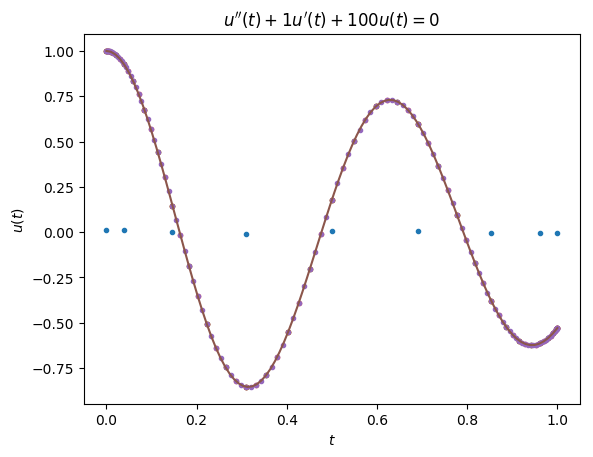

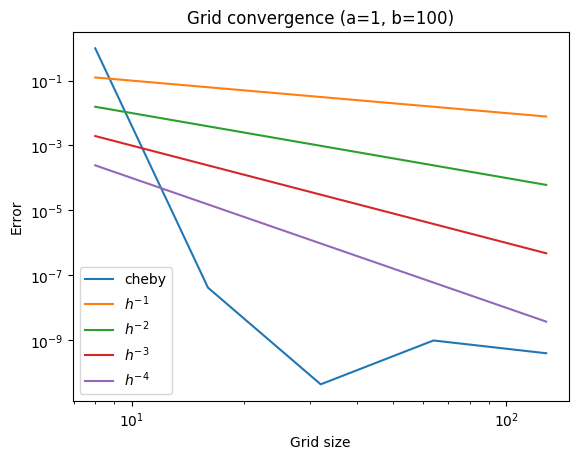

In [2]:
a = 1
b = 100

sizes = collect(2 .^ (3:7))
diffs = map(sizes) do i
    x, L, rhs = cheb_problem(i, a, b, x -> 0)
    plot(x, L\rhs, ".", label="$i")
    norm(L\rhs - exact(a,b).(x), Inf)
end
xlabel("\$t\$")
ylabel("\$u(t)\$")
title("\$u''(t) + $a u'(t) + $b u(t) = 0\$")
xx = linspace(0,1,100)
plot(xx, exact(a,b).(xx))

figure()
title("Grid convergence (a=$a, b=$b)")
xlabel("Grid size")
ylabel("Error")
loglog(sizes, diffs, label="cheby")
x = linspace(sizes[1], sizes[end])
for i in 1:4
    loglog(x, x .^ -i, label="\$h^{-$i}\$")
end
legend();

It appears that we have spectral convergence.

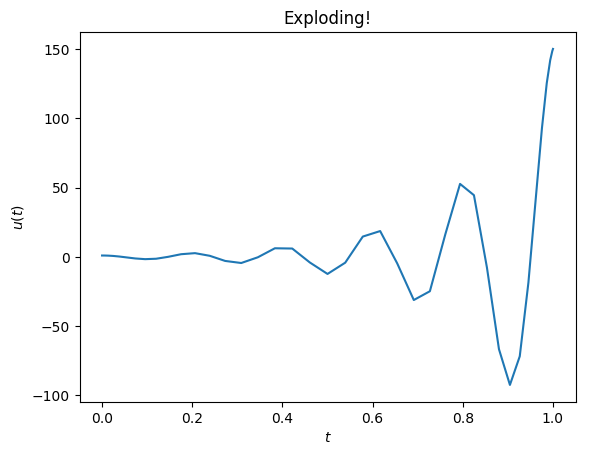

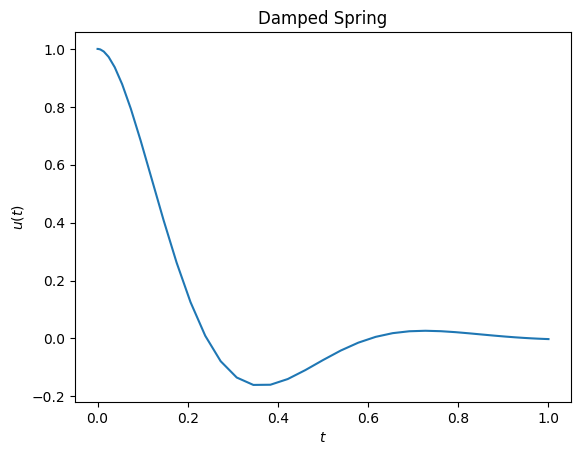

In [3]:
a = -10
b = 1000
x, L, rhs = cheb_problem(40, a, b, x -> 0)
figure()
xlabel("\$t\$")
ylabel("\$u(t)\$")
title("Exploding!")
plot(x, L\rhs)

a = 10
b = 100
x, L, rhs = cheb_problem(40, a, b, x -> 0)
figure()
xlabel("\$t\$")
ylabel("\$u(t)\$")
title("Damped Spring")
plot(x, L\rhs);